In [2]:
import os
import random
import math
import cv2
import json
import numpy as np
import pandas as pd

In [3]:
import numpy as np

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
from shutil import copyfile,copy2
from PIL import Image

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
pip show keras

Name: keras
Version: 2.7.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\ruhiy\appdata\local\programs\python\python39\lib\site-packages
Requires: 
Required-by: tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip show numpy

Name: numpy
Version: 1.21.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: c:\users\ruhiy\appdata\local\programs\python\python39\lib\site-packages
Requires: 
Required-by: h5py, Keras-Preprocessing, matplotlib, opencv-python, opt-einsum, pandas, scikit-learn, scipy, tensorboard, tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 2.7.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\ruhiy\appdata\roaming\python\python39\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wheel, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip show pandas

Name: pandas
Version: 1.3.5
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: c:\users\ruhiy\appdata\local\programs\python\python39\lib\site-packages
Requires: numpy, python-dateutil, pytz
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip show IPython

Name: ipythonNote: you may need to restart the kernel to use updated packages.

Version: 7.24.1
Summary: IPython: Productive Interactive Computing
Home-page: https://ipython.org
Author: The IPython Development Team
Author-email: ipython-dev@python.org
License: BSD
Location: c:\users\ruhiy\appdata\local\programs\python\python39\lib\site-packages
Requires: backcall, colorama, decorator, jedi, matplotlib-inline, pickleshare, prompt-toolkit, pygments, setuptools, traitlets
Required-by: ipykernel, ipywidgets, jupyter-console


In [10]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [11]:
import keras
keras.__version__

'2.7.0'

In [18]:
BASE_DIR = r'C:\Users\ruhiy\Documents\Machine Learning\Distracted Driver Detection\DDD Model Creation'

In [19]:
DATA_DIR = os.path.join(BASE_DIR, r'state-farm-distracted-driver-detection')
print(DATA_DIR)

C:\Users\ruhiy\Documents\Machine Learning\Distracted Driving\distracted_driver\state-farm-distracted-driver-detection


In [20]:
TRAIN_DIR = os.path.join(DATA_DIR, r'imgs\train')
TEST_DIR = os.path.join(DATA_DIR, r'imgs\test')

In [21]:
model_description = 'model_vgg16'
model_file = model_description + '.h5'

Create training, test, and validation datasets

In [22]:
csv = pd.read_csv(os.path.join(DATA_DIR, 'driver_imgs_list.csv'))

In [23]:
csv

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [24]:
csv = csv.values

In [25]:
csv

array([['p002', 'c0', 'img_44733.jpg'],
       ['p002', 'c0', 'img_72999.jpg'],
       ['p002', 'c0', 'img_25094.jpg'],
       ...,
       ['p081', 'c9', 'img_25946.jpg'],
       ['p081', 'c9', 'img_67850.jpg'],
       ['p081', 'c9', 'img_9684.jpg']], dtype=object)

In [26]:
csv[0][1]

'c0'

In [27]:
# create directory structure for storing datasets
datasets = ['train', 'test', 'validate']
NUM_CLASSES = 10
for i in datasets: 
    dataset_path = os.path.join(BASE_DIR, i)
    if (not(os.path.exists(dataset_path))):
        os.mkdir(dataset_path)
    for j in range(0, NUM_CLASSES): 
        class_path = os.path.join(dataset_path, 'c' + str(j))
        if (not(os.path.exists(class_path))):
            os.mkdir(class_path)

In [28]:
# copy images from original train dataset into folders for train, 
# test, and validate while maintaining original folder structure.
# divide the images in the train dataset as follows:
# 25% of train images are test images
# 10% of the remaining 75% are validation images
# 90% of the remaining 75% are used for training

i = j = 1
for row in csv:
    classname = row[1]
    img = row[2]
    if i % 4 == 0: # copy image into test dataset
        dest_img = os.path.join(BASE_DIR, datasets[1], classname, img)
        src_img = os.path.join(TRAIN_DIR, classname, img) 
        copy2(src_img, dest_img)
    else:
        if j % 10 == 0: # copy image into validate dataset
            dest_img = os.path.join(BASE_DIR, datasets[2], classname, img)
            src_img = os.path.join(TRAIN_DIR, classname, img) 
            copy2(src_img, dest_img)
        else:
            dest_img = os.path.join(BASE_DIR, datasets[0], classname, img)
            src_img = os.path.join(TRAIN_DIR, classname, img) 
            copy2(src_img, dest_img)
    
    i += 1
    j += 1
    

In [29]:
# check how many images are copied to all directories
from functools import reduce
def count_files(dir):
    return reduce(lambda x, y: x + y, ([len(files) for r, d, files in os.walk(dir)]))

sum = 0
for i in datasets:
    sum += count_files(os.path.join(BASE_DIR, i))
    print(sum)

15697
21303
22424


In [30]:
def preProcess(x):
    mean_pixel = [103.939, 116.779, 123.68]
    x[0, :, :] -= mean_pixel[0]
    x[1, :, :] -= mean_pixel[1]
    x[2, :, :] -= mean_pixel[2]
    return x

In [31]:
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model

img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

model_orig = VGG16(include_top=True, input_shape=input_shape)

# Add a layer where input is the output of the  second last layer
x = Dense(NUM_CLASSES, activation='softmax', name='predictions')(model_orig.layers[-2].output)

# Then create the corresponding model
vgg16_model = Model(model_orig.input, x)

# compile the model
vgg16_model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.0001, momentum=0.9),
                        metrics=['acc'])

In [32]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [33]:
from keras.callbacks import EarlyStopping, Callback

callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    ]

In [34]:
test_datagen = ImageDataGenerator(preprocessing_function = preProcess)
train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest',
        preprocessing_function = preProcess)

In [35]:
# generate train and validate dataframes and train model
train_data_dir = os.path.join(BASE_DIR, datasets[0])
validate_data_dir = os.path.join(BASE_DIR, datasets[2])

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validate_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')


history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples / train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples / validation_generator.batch_size,
    verbose=1,
    callbacks=callbacks
    )


Found 15697 images belonging to 10 classes.
Found 1121 images belonging to 10 classes.
Epoch 1/10
490/490 [==============================] - 146s 273ms/step - loss: 0.7538 - acc: 0.7463 - val_loss: 0.1425 - val_acc: 0.9518
Epoch 2/10
490/490 [==============================] - 128s 261ms/step - loss: 0.1433 - acc: 0.9559 - val_loss: 0.0519 - val_acc: 0.9822
Epoch 3/10
490/490 [==============================] - 130s 265ms/step - loss: 0.0799 - acc: 0.9748 - val_loss: 0.0334 - val_acc: 0.9893
Epoch 4/10
490/490 [==============================] - 130s 264ms/step - loss: 0.0558 - acc: 0.9817 - val_loss: 0.0371 - val_acc: 0.9893
Epoch 5/10
490/490 [==============================] - 130s 264ms/step - loss: 0.0395 - acc: 0.9885 - val_loss: 0.0226 - val_acc: 0.9929
Epoch 6/10
490/490 [==============================] - 128s 260ms/step - loss: 0.0321 - acc: 0.9901 - val_loss: 0.0187 - val_acc: 0.9938
Epoch 7/10
490/490 [==============================] - 128s 259ms/step - loss: 0.0266 - acc: 0.991

In [46]:
def save_model(model_to_save, model_string):
    model_fname_h5 = model_string + '.h5'
    model_to_save.save(model_fname_h5)
    print('saved model', model_fname_h5)
    
# save the model
save_model(model_to_save=vgg16_model, model_string=model_description)

saved model model_vgg16.h5


In [47]:
from keras.models import load_model
test_model = load_model(model_file)

In [48]:
test_data_dir = os.path.join(BASE_DIR, datasets[1])
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
        )

Found 5606 images belonging to 10 classes.


In [49]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

# run the model and get most-likely class
predictions = test_model.predict(
    test_generator, 
    verbose=1
    )

176/176 [==============================] - 12s 66ms/step


In [50]:
predicted_classes = np.argmax(predictions, axis=1)  # y_pred

# get ground-truth classes and class labels
true_classes = test_generator.classes  # y_val

class_labels = list(test_generator.class_indices.keys())

In [51]:
predicted_classes

array([0, 0, 0, ..., 9, 8, 9], dtype=int64)

In [52]:
true_classes

array([0, 0, 0, ..., 9, 9, 9])

In [53]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(true_classes, predicted_classes)
print(confusion_matrix)

[[608   1   0   0   1   0   0   0   0  12]
 [  0 564   0   0   0   0   1   0   0   0]
 [  0   0 578   0   0   0   1   0   0   0]
 [  1   0   0 585   1   0   0   0   0   0]
 [  0   0   0   0 580   0   1   0   0   0]
 [  1   0   1   0   0 574   0   0   1   1]
 [  0   0   0   0   0   0 581   0   0   0]
 [  0   0   0   0   0   0   0 500   0   1]
 [  0   1   0   0   0   0   4   0 472   1]
 [  0   0   0   0   1   0   0   0   2 531]]


Confusion Matrix

Confusion matrix, without normalization
[[608   1   0   0   1   0   0   0   0  12]
 [  0 564   0   0   0   0   1   0   0   0]
 [  0   0 578   0   0   0   1   0   0   0]
 [  1   0   0 585   1   0   0   0   0   0]
 [  0   0   0   0 580   0   1   0   0   0]
 [  1   0   1   0   0 574   0   0   1   1]
 [  0   0   0   0   0   0 581   0   0   0]
 [  0   0   0   0   0   0   0 500   0   1]
 [  0   1   0   0   0   0   4   0 472   1]
 [  0   0   0   0   1   0   0   0   2 531]]


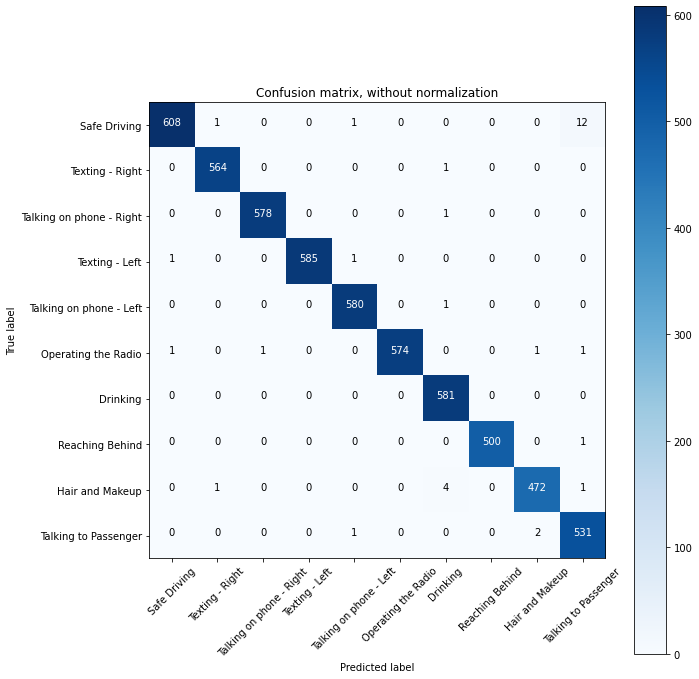

In [54]:
#confusion matrix vgg16
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ["Safe Driving","Texting - Right","Talking on phone - Right","Texting - Left","Talking on phone - Left"
              ,"Operating the Radio", "Drinking", "Reaching Behind", "Hair and Makeup","Talking to Passenger"
              ]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
# plt.figure()
cnf_matrix = confusion_matrix(true_classes, predicted_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure(figsize=(8,8))
# np.set_printoptions(precision=2)

# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()